In [1]:
#instalação da biblioteca de emojis
!pip install emoji

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 216 kB 4.9 MB/s 
  Created wheel for emoji: filename=emoji-2.1.0-py3-none-any.whl size=212392 sha256=52de578f32bdb097ce48ced2f5241695b7acc7881bcf44dd6a0952e6ee6e4c51
  Stored in directory: /root/.cache/pip/wheels/77/75/99/51c2a119f4cfd3af7b49cc57e4f737bed7e40b348a85d82804
Successfully built emoji


In [2]:
import re
import os
import emoji
import spacy
import string
import requests
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
%matplotlib inline

# Webscraping

criando função para fazer dataset de texto a partir de 3 editorias determinadas no site.

In [3]:
seed_urls = ['https://inshorts.com/en/read/technology',
             'https://inshorts.com/en/read/sports',
             'https://inshorts.com/en/read/world']

def build_dataset(seed_urls):
    news_data = []
    for url in seed_urls:
        news_category = url.split('/')[-1]
        data = requests.get(url)
        soup = BeautifulSoup(data.content, 'html.parser')
        
        news_articles = [{'news_headline': headline.find('span', 
                                                         attrs={"itemprop": "headline"}).string,
                          'news_article': article.find('div', 
                                                       attrs={"itemprop": "articleBody"}).string,
                          'news_category': news_category}
                         
                            for headline, article in 
                             zip(soup.find_all('div', 
                                               class_=["news-card-title news-right-box"]),
                                 soup.find_all('div', 
                                               class_=["news-card-content news-right-box"]))
                        ]
        news_data.extend(news_articles)
        
    df =  pd.DataFrame(news_data)
    df = df[['news_headline', 'news_article', 'news_category']]
    return df

In [4]:
news_df = build_dataset(seed_urls)
news_df.head(10)

,news_headline,news_article,news_category
0,"AI reduces 1,00,000-equation quantum physics p...",Physicists have compressed a quantum physics p...,technology
1,Apple reverses plan to increase iPhone 14 prod...,Apple has reportedly reversed its plans to inc...,technology
2,Crypto lender Celsius' CEO Alex Mashinsky step...,Cryptocurrency lender Celsius Network's CEO Al...,technology
3,Customers criticise Flipkart after iPhone 13 o...,Flipkart has responded after several customers...,technology
4,Musk's own data scientists couldn't support hi...,Tesla CEO Elon Musk’s own data scientists coul...,technology
5,Apple removes Russia's 2nd largest tech firm's...,Apple has removed a series of apps owned by VK...,technology
6,Zuckerberg drops out of top 10 on Forbes US' 4...,Meta CEO Mark Zuckerberg isn’t among the top 1...,technology
7,Meta apologises for some posts seen by UK teen...,Meta executive Elizabeth Lagone has apologised...,technology
8,Mobile phone manufacturers must mandatorily re...,Department of Telecom has mandated mobile phon...,technology
9,I'm moving to Rumble: Russell Brand as YouTube...,English actor Russell Brand criticised YouTube...,technology


In [5]:
news_df.to_csv('news_df_mentorama.csv')

Para saber:

- *Token*: uma unidade do texto, pode ser uma palavra, uma frase, etc. 
- *Documento*: uma sequencia de tokens, por exemplo um livro ou um artigo 
- *Corpus*: um conjunto de documentos. 
- *Document Term Matrix*: uma matrix que descreve a frequencia de termos em um corpus
- *Stopwords*: palavras que não contém informação, que ocorrem com muita frequência.

Definindo função que processa o texto e retorna o texto tokenizado e sem stopwords, emoji, pontuação e números, etc:

In [6]:
def preprocess_text(text, remove_stop = True, stem_words = False, remove_mentions_hashtags = True):
    """
    eg:
    input: preprocess_text("@water #dream hi hello where are you going be there tomorrow happening happen happens",  
    stem_words = True) 
    output: ['tomorrow', 'happen', 'go', 'hello']
    """

    # Remove emojis
    emoji_pattern = re.compile("[" "\U0001F1E0-\U0001F6FF" "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r"", text)
    text = "".join([x for x in text if x not in emoji.EMOJI_DATA]) 

    if remove_mentions_hashtags:
        text = re.sub(r"@(\w+)", " ", text)
        text = re.sub(r"#(\w+)", " ", text)

    text = re.sub(r"[^\x00-\x7F]+", " ", text)
    regex = re.compile('[' + re.escape(string.punctuation) + '0-9\\r\\t\\n]') # remove punctuation and numbers
    nopunct = regex.sub(" ", text.lower())
    words = (''.join(nopunct)).split()

    if(remove_stop):
        words = [w for w in words if w not in ENGLISH_STOP_WORDS]
        words = [w for w in words if len(w) > 2]  # remove a,an,of etc.

    if(stem_words):
        stemmer = PorterStemmer()
        words = [stemmer.stem(w) for w in words]

    return list(words)

In [7]:
rows, cols = news_df.shape

In [8]:
#processando os textos
news_df['token'] = [preprocess_text(news_df["news_article"][row]) for row in range(rows)]

In [9]:
news_df.head()

,news_headline,news_article,news_category,token
0,"AI reduces 1,00,000-equation quantum physics p...",Physicists have compressed a quantum physics p...,technology,"[physicists, compressed, quantum, physics, pro..."
1,Apple reverses plan to increase iPhone 14 prod...,Apple has reportedly reversed its plans to inc...,technology,"[apple, reportedly, reversed, plans, increase,..."
2,Crypto lender Celsius' CEO Alex Mashinsky step...,Cryptocurrency lender Celsius Network's CEO Al...,technology,"[cryptocurrency, lender, celsius, network, ceo..."
3,Customers criticise Flipkart after iPhone 13 o...,Flipkart has responded after several customers...,technology,"[flipkart, responded, customers, took, social,..."
4,Musk's own data scientists couldn't support hi...,Tesla CEO Elon Musk’s own data scientists coul...,technology,"[tesla, ceo, elon, musk, data, scientists, cou..."


# Word Embedding

Depois que temos o texto com tokens, vamos usar uma rede neural que recebe palavras e entrega vetores que representam ela em um espaço vetorial. 

# documentação importante:
https://spacy.io/usage

In [10]:
!python -m spacy download en_core_web_md

2022-09-28 17:11:37.519597: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 42.8 MB 200 kB/s 
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')


In [11]:
import spacy

In [12]:
nlp = spacy.load('en_core_web_md')

In [13]:
# definindo função que retorna os vetores para cada palavra:
def vec(s):
    return nlp.vocab[s].vector

# Vetorizando cada palavra. 
Aqui, como cada documento tem um número diferente de palavras, vamos ter matrizes com diferentes dimensões. Nosso objetivo final é conseguir representar cada documento como um vetor que resume o documento. Ou seja, queremos representar diferentes matrizes como vetores. Existem várias formas de fazer isso (média dos vetores, média ponderada pelo TF-IDF, PCA...), mas nesse teste vamos fazer uma média simples. 

In [14]:
vec_size = 300
list_of_matrix = []
for corpus in news_df['token']:
    matrix = np.empty([len(corpus), vec_size])
    for idx, word in enumerate(corpus):
        matrix[idx,:] = vec(word)
    list_of_matrix.append(matrix)

In [15]:
final_feature_matrix = np.empty([rows, vec_size])

for row in range(rows):
    final_feature_matrix[row,:] = list_of_matrix[row].mean(axis = 0)

In [16]:
final_feature_matrix.shape

(75, 300)

# Clusterização de matérias:

Agora que temos um vetor que representa cada documento, vamos usar algum método de clusterização pra tentar recuperar as editorias selecionadas lá no início. Vamos rodar um k-means em cada vetor que representa um documento e (como é um teste), pedir 3 clusters para ele. 

In [17]:
from sklearn.cluster import KMeans
import numpy as np
kmeans = KMeans(n_clusters=3, random_state=0).fit(final_feature_matrix)
kmeans.labels_

array([1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1,
       1, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 2, 1, 2, 1, 2, 0, 2, 0, 1, 2, 1, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2], dtype=int32)

Vamos ver como o k-means separou cada grupo e olhar o label verdadeiro para validar nosso método:

In [18]:
print(news_df["news_category"][kmeans.labels_ == 0]) 
print(news_df["news_category"][kmeans.labels_ == 1])
print(news_df["news_category"][kmeans.labels_ == 2])

6     technology
7     technology
25        sports
26        sports
27        sports
28        sports
29        sports
30        sports
31        sports
32        sports
33        sports
34        sports
35        sports
36        sports
37        sports
38        sports
39        sports
40        sports
41        sports
42        sports
43        sports
44        sports
45        sports
46        sports
47        sports
48        sports
49        sports
55         world
57         world
Name: news_category, dtype: object
0     technology
1     technology
2     technology
3     technology
4     technology
5     technology
8     technology
9     technology
10    technology
11    technology
12    technology
13    technology
14    technology
16    technology
17    technology
18    technology
19    technology
20    technology
21    technology
22    technology
24    technology
51         world
53         world
58         world
60         world
Name: news_category, dtype: object
15    techno

Conseguimos separar bem as editorias por assuntos.

# Notícia mais similar usando distância euclidiana

Vamos agora tentar identificar, dado um documento, qual é o documento mais similar a ele. 

In [19]:
def get_closest(list_of_articles, article_position, df):
    article_vec = list_of_articles[article_position,:]
    other_vec = np.delete(list_of_articles, article_position, 0)
    from scipy import spatial
    A = [other_vec[row,:] for row in range(other_vec.shape[0])]
    tree = spatial.KDTree(A)
    closest_position = tree.query(article_vec)[1]
    print(df[article_position])
    print(df[closest_position])
    return tree.query(article_vec)[0], closest_position

In [20]:
get_closest(final_feature_matrix, 30, news_df["news_article"])

Iceland Cricket took to Twitter to troll the England and Wales Cricket Board (ECB) over their reported offer to host India-Pakistan Test matches. "We officially announce to ICC that we're also offering to do the same & can provide near 24-hour daylight in June and July, as well as better tweets covering the matches. Sniper security too," Iceland Cricket wrote.
Ahead of the first T20I against India, South Africa captain Temba Bavuma, who recently went unsold in the SA20 league auction, has said his focus is on making sure that they are in the best possible space going into the T20 WC later this year. "All the other distractions, side-shows...I will deal with on a personal level," he added. 


(11.70656090185322, 39)

# Explorando visualmente os resultados encontrados

Como estamos lidando com uma dimensão elevada (300) para cada documento, não conseguimos visualizar com clareza o que estamos clusterizando. Um método simples que permite explorar os resultados obtidos é reduzir a dimensão do problema para 2, 3 e fazer gráficos exploratórios que permitam visualizar os dados.


In [21]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(final_feature_matrix)
principalDf = pd.DataFrame(data = principalComponents
             ,columns = ['principal component 1', 'principal component 2'])

In [22]:
pca.explained_variance_ratio_

array([0.20219864, 0.0928963 ])

Aqui, vamos plotar o gráfico dos dois primeiros componentes e colorir eles com a cor associada à editoria real dele.

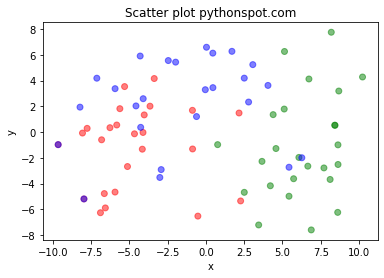

In [23]:
import numpy as np
import matplotlib.pyplot as plt

# Create data

x = principalDf['principal component 1']
y = principalDf['principal component 2']

# Plot

colors = {'technology':'red', 'world':'blue', 'sports':'green'}
plt.scatter(x, y, alpha=0.5, c = news_df['news_category'].apply(lambda x: colors[x]))
plt.title('Scatter plot pythonspot.com')
plt.xlabel('x')
plt.ylabel('y')
plt.show()